## Setup

In [5]:
import os
os.environ["R_HOME"] = "/Library/Frameworks/R.framework/Resources"

In [6]:
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline  
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 100)

import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore") # Ignore all warnings
# warnings.filterwarnings("ignore", category=RRuntimeWarning) # Show some warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

In [7]:
%%javascript
// Disable auto-scrolling
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## TidyCensus Example

This notebook grabs data from the US Census using the [tidycensus package in R](https://walker-data.com/tidycensus/index.html). Make sure you have installed the `tidyverse` and `tidycensus` packages.

In [8]:
%%R 

library(tidycensus)
library(tidyverse)

# store any shapefiles we grab from the census in ~/Library/Caches/tigris
# in case the government removes the shapefiles FTP server again 😭
options(tigris_use_cache = TRUE)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.6
✔ forcats   1.0.1     ✔ stringr   1.6.0
✔ ggplot2   4.0.1     ✔ tibble    3.3.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.2
✔ purrr     1.2.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


### Step 1 \| Load Census API key from `.env` file

The `.env` file should look like this:

```bash
CENSUS_API_KEY="your-api-key-here"
```

This is what is known as an environment variable. 

We load it below in Python

In [2]:
from dotenv import load_dotenv
load_dotenv() # <- searches for a file named .env and loads the environment variables in it

False

And in this cell we pass the environment variable to tidycensus in R

In [9]:
%%R 

census_api_key(Sys.getenv("CENSUS_API_KEY")) # <- Loads CENSUS_API_KEY from environment variable and sets it in R

To install your API key for use in future sessions, run this function with `install = TRUE`.


### Step 2 \| Figure out what tables you want data from and at what geographic granularity

Use <https://censusreporter.org/> to figure out which tables you want.

-   Scroll to the bottom of the page to see the tables.
-   If you already know the table ID, stick that in the "Explore" section to learn more about that table.

Note, you probably always want population variable (B01003_001) which we found in censusreporter here: https://censusreporter.org/tables/B01003/

- find some other variables that you're also interested in
- don't forget to pick a geography like "tract", "county" or "block group". here is the list of [all geographies](https://walker-data.com/tidycensus/articles/basic-usage.html#geography-in-tidycensus
).

👉 use the code from the example notebooks to get the variables you're interested in. feel free to use ChatGPT for help

In [61]:
%%R 

# this code is incomplete, refer to example notebooks
# and use chat gpt for help getting census variables
nyc_census_data <- get_acs(geography = "tract", 
                      state='NY',
                      county = c("New York", "Kings", "Queens", "Bronx", "Richmond"),
                      variables = c(
                        population="B01003_001",
                        age="B01002D_001",
                        med_inc="B19013_001",
                        education="B14001_001",
                        asian_pop="B02001_005"  
                      ), 
                      year = 2021,
                      survey="acs5",
                      geometry=T)

nyc_census_data

Simple feature collection with 11635 features and 5 fields (with 5 geometries empty)
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -74.25609 ymin: 40.4961 xmax: -73.70036 ymax: 40.91771
Geodetic CRS:  NAD83
First 10 features:
         GEOID                                      NAME   variable estimate
1  36081014700 Census Tract 147, Queens County, New York        age     42.7
2  36081014700 Census Tract 147, Queens County, New York population   2863.0
3  36081014700 Census Tract 147, Queens County, New York  asian_pop    340.0
4  36081014700 Census Tract 147, Queens County, New York  education   2787.0
5  36081014700 Census Tract 147, Queens County, New York    med_inc  71815.0
6  36047058400  Census Tract 584, Kings County, New York        age     39.3
7  36047058400  Census Tract 584, Kings County, New York population   3655.0
8  36047058400  Census Tract 584, Kings County, New York  asian_pop    787.0
9  36047058400  Census Tract 584, Kings County, New York  ed

Getting data from the 2017-2021 5-year ACS
Using FIPS code '36' for state 'NY'
Using FIPS code '061' for 'New York County'
Using FIPS code '047' for 'Kings County'
Using FIPS code '081' for 'Queens County'
Using FIPS code '005' for 'Bronx County'
Using FIPS code '085' for 'Richmond County'


### Step 3 | Pivot to Wide Format

Pivot from long to wide using `pivot_wider`.

Depending on what you're trying to do, you may want the data in long or wide format. This example pivots the data to wide format, which will help us with mapping later on in the notebook.

In [64]:
%%R 

nyc_census_data <- nyc_census_data %>% 
  pivot_wider(
    names_from=variable, 
    values_from = c(estimate, moe),
    names_glue = "{variable}_{.value}"
  ) # pivot from wide to long

nyc_census_data

Simple feature collection with 2327 features and 12 fields (with 1 geometry empty)
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -74.25609 ymin: 40.4961 xmax: -73.70036 ymax: 40.91771
Geodetic CRS:  NAD83
# A tibble: 2,327 × 13
   GEOID       NAME                    geometry age_estimate population_estimate
   <chr>       <chr>         <MULTIPOLYGON [°]>        <dbl>               <dbl>
 1 36081014700 Censu… (((-73.9137 40.76548, -7…         42.7                2863
 2 36047058400 Censu… (((-73.96103 40.59616, -…         39.3                3655
 3 36061006900 Censu… (((-74.02064 40.73039, -…         25.6                2450
 4 36047073000 Censu… (((-73.93345 40.6257, -7…         10                  2676
 5 36047100400 Censu… (((-73.90735 40.63083, -…         41.7                3004
 6 36047055700 Censu… (((-73.96279 40.72256, -…         38                  1834
 7 36005022101 Censu… (((-73.92012 40.83759, -…         48.1                4030
 8 36081047000 Censu… 

### Step 4 | Do calculations with `mutate`

In R, you can use `mutate` to create new columns or modify existing ones.

👉 In this step, do any calculations you need (for example if you have the total black population, but you want it as a percent of total population in a census tract, you may have to do some division)

In [65]:
%%R 

# your code here. refer to example notebooks for help

nyc_census_data <- nyc_census_data %>% 
    mutate(
        borough = str_split(NAME, ",") %>% map_chr(2) %>% str_trim(),
        asian_percent = asian_pop_estimate / population_estimate * 100
    ) 

nyc_census_data


Simple feature collection with 2327 features and 14 fields (with 1 geometry empty)
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -74.25609 ymin: 40.4961 xmax: -73.70036 ymax: 40.91771
Geodetic CRS:  NAD83
# A tibble: 2,327 × 15
   GEOID       NAME                    geometry age_estimate population_estimate
 * <chr>       <chr>         <MULTIPOLYGON [°]>        <dbl>               <dbl>
 1 36081014700 Censu… (((-73.9137 40.76548, -7…         42.7                2863
 2 36047058400 Censu… (((-73.96103 40.59616, -…         39.3                3655
 3 36061006900 Censu… (((-74.02064 40.73039, -…         25.6                2450
 4 36047073000 Censu… (((-73.93345 40.6257, -7…         10                  2676
 5 36047100400 Censu… (((-73.90735 40.63083, -…         41.7                3004
 6 36047055700 Censu… (((-73.96279 40.72256, -…         38                  1834
 7 36005022101 Censu… (((-73.92012 40.83759, -…         48.1                4030
 8 36081047000 Censu… 

### Step 5 | Example Plots

Use histograms or dotplots to view the distributions

`stat_bin()` using `bins = 30`. Pick better value `binwidth`.


R callback write-console: In addition:   
R callback write-console: Warning message:
  
R callback write-console: Removed 411 rows containing non-finite outside the scale range (`stat_bin()`). 
  


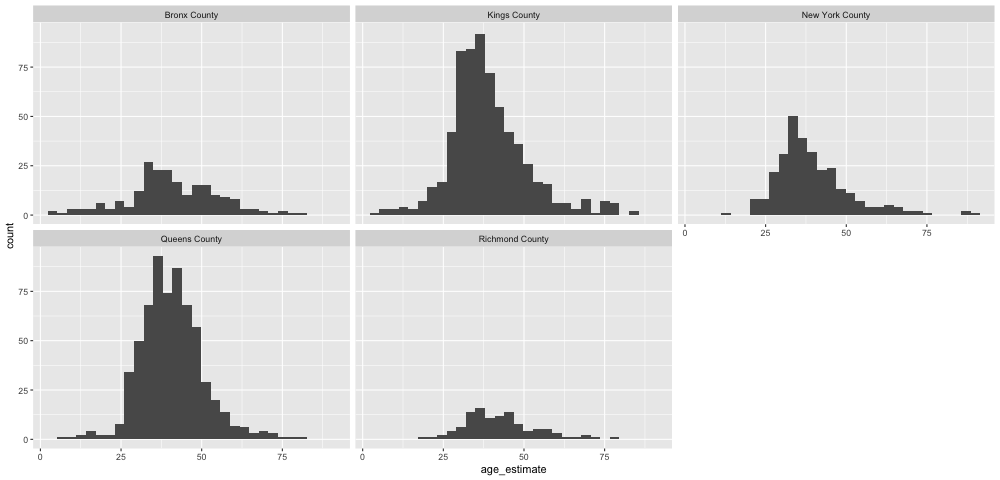

In [46]:
%%R -w 1000

ggplot()


# your code here. refer to example notebooks for help
ggplot(nyc_census_data) + 
    aes(x=age_estimate) +
    geom_histogram() + 
    facet_wrap(~borough) 



R callback write-console: In addition:   
R callback write-console: Warning messages:
  
R callback write-console: 1: Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.
This warning is displayed once per session.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was
generated. 
  
R callback write-console: 2: Removed 411 rows containing non-finite outside the scale range
(`stat_boxplot()`). 
  
R callback write-console: 3: The following aesthetics were dropped during statistical transformation: size.
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor? 
  
R callback write-console: 4: Removed 411 rows containing missing values or values outside the scale range
(`geom_point()`). 
  


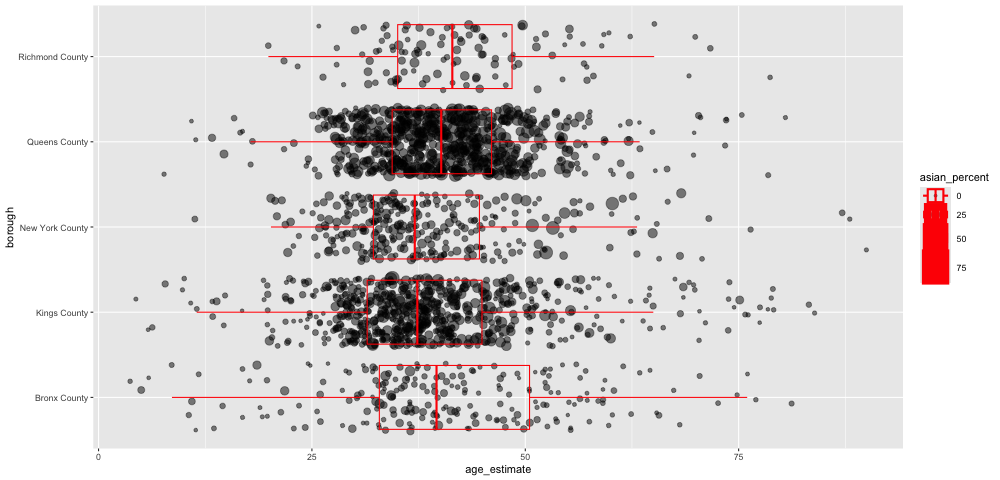

In [66]:
%%R -w 1000

ggplot(nyc_census_data) + 
    aes(x=age_estimate, y=borough, size=asian_percent) +
    geom_jitter(alpha=0.5) + 
    # overlay a box and whisker plot that is transparent with no outliers and is red
    geom_boxplot(fill=NA, outlier.shape=NA, color="red") 

### Step 6 \| Example Map

See more details about making maps here:

https://walker-data.com/tidycensus/articles/spatial-data.html

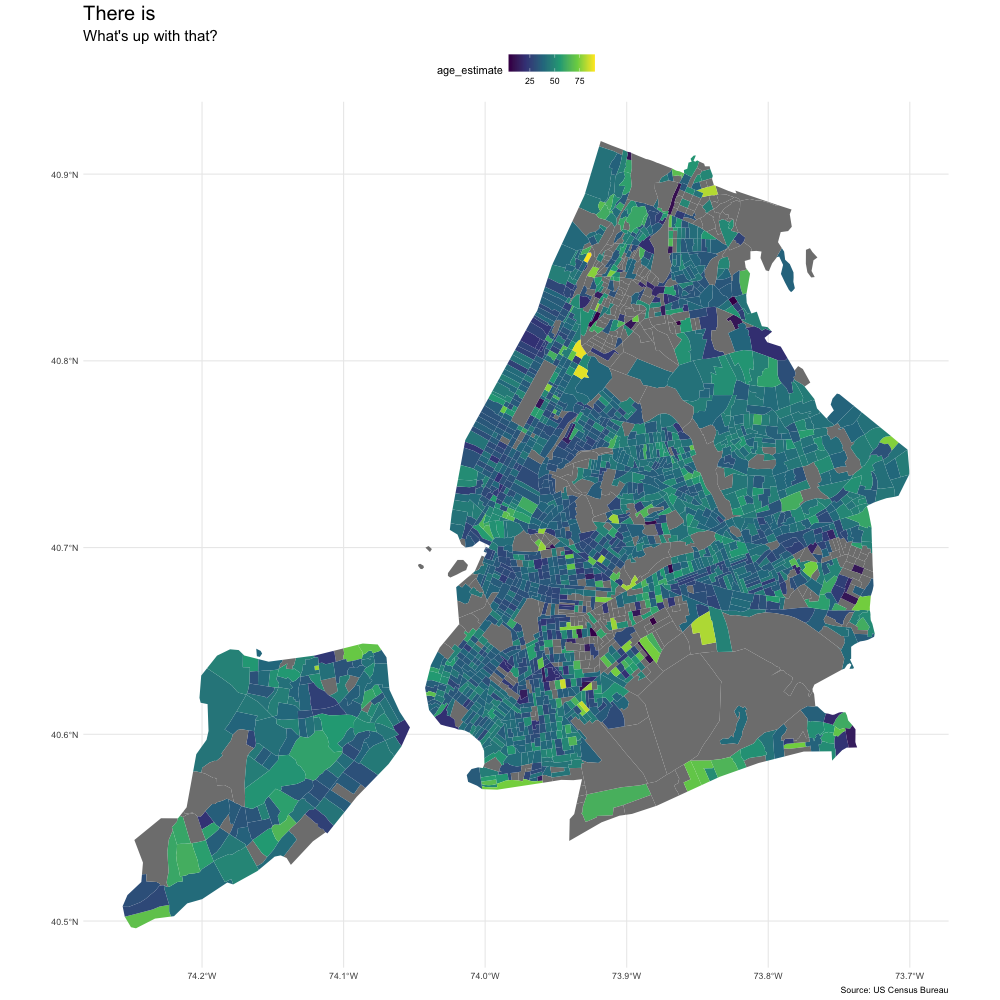

In [57]:
%%R -w 1000 -h 1000
# your code here. refer to example notebooks for help

ggplot(nyc_census_data) +
  geom_sf(aes(fill = age_estimate), color = NA) +
  scale_fill_viridis_c() +
  theme_minimal() +
    labs(
    title = "There is ",
    subtitle = "What's up with that?",
    caption = "Source: US Census Bureau"
  ) +
  theme(
    #make title and subitle bigger
    plot.title = element_text(size = 20),
    plot.subtitle = element_text(size = 15),
    # move legend to top
    legend.position = "top")


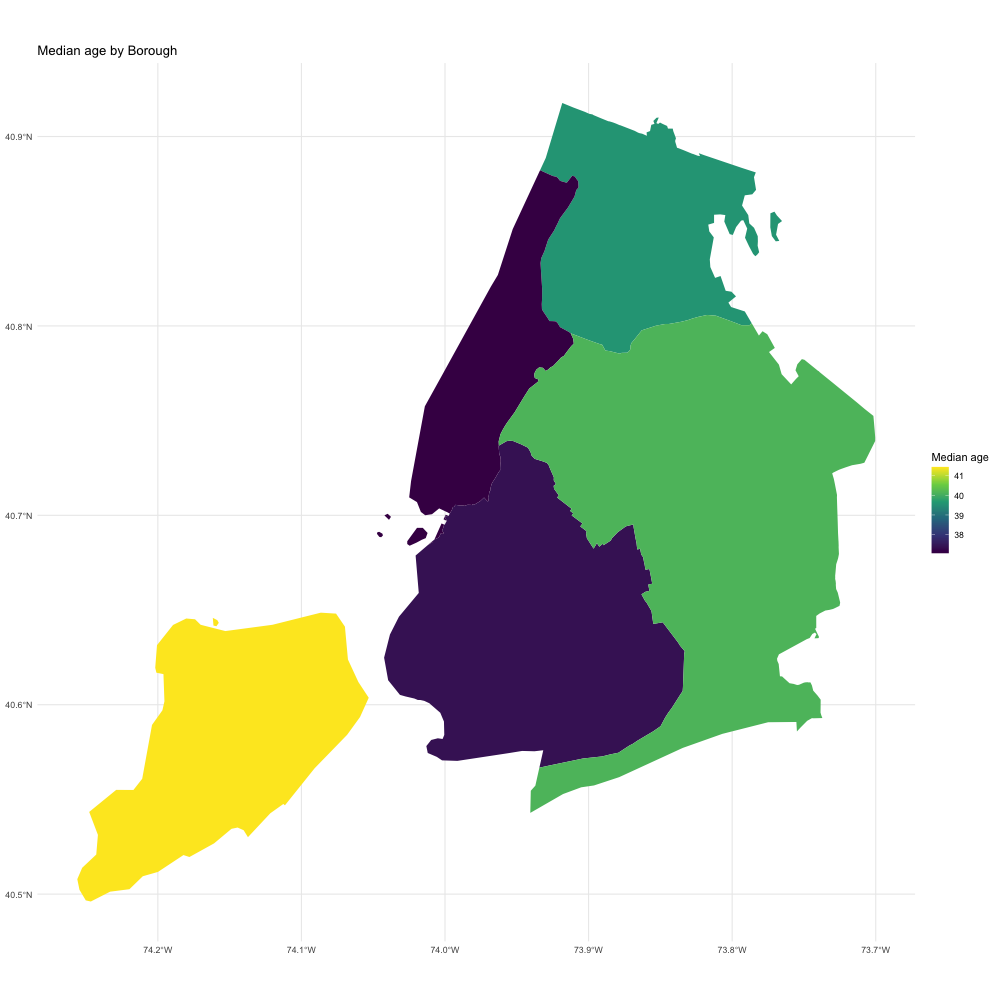

In [56]:
%%R -w 1000 -h 1000

library(dplyr)
library(sf)

borough_sf <- nyc_census_data %>%
  group_by(borough) %>%
  summarise(
    age_med = median(age_estimate, na.rm = TRUE),
    geometry = st_union(geometry),
    .groups = "drop"
  )

ggplot(borough_sf) +
  geom_sf(aes(fill = age_med), color = NA) +
  scale_fill_viridis_c() +
  theme_minimal() +
  labs(title = "Median age by Borough", fill = "Median age")


In [58]:
%%R

nyc_census_data %>%
  st_drop_geometry() %>%
  arrange(desc(age_estimate)) %>%
  select(NAME, age_estimate, borough) %>%
  head(20)


# A tibble: 20 × 3
   NAME                                           age_estimate borough        
   <chr>                                                 <dbl> <chr>          
 1 Census Tract 277, New York County, New York            90   New York County
 2 Census Tract 242, New York County, New York            88   New York County
 3 Census Tract 178, New York County, New York            87.1 New York County
 4 Census Tract 742, Kings County, New York               83.9 Kings County   
 5 Census Tract 652, Kings County, New York               83.2 Kings County   
 6 Census Tract 426, Bronx County, New York               81.2 Bronx County   
 7 Census Tract 892.01, Queens County, New York           80.5 Queens County  
 8 Census Tract 1142.01, Kings County, New York           79.1 Kings County   
 9 Census Tract 417, Kings County, New York               79   Kings County   
10 Census Tract 676, Kings County, New York               78.8 Kings County   
11 Census Tract 133.01, Richmond 

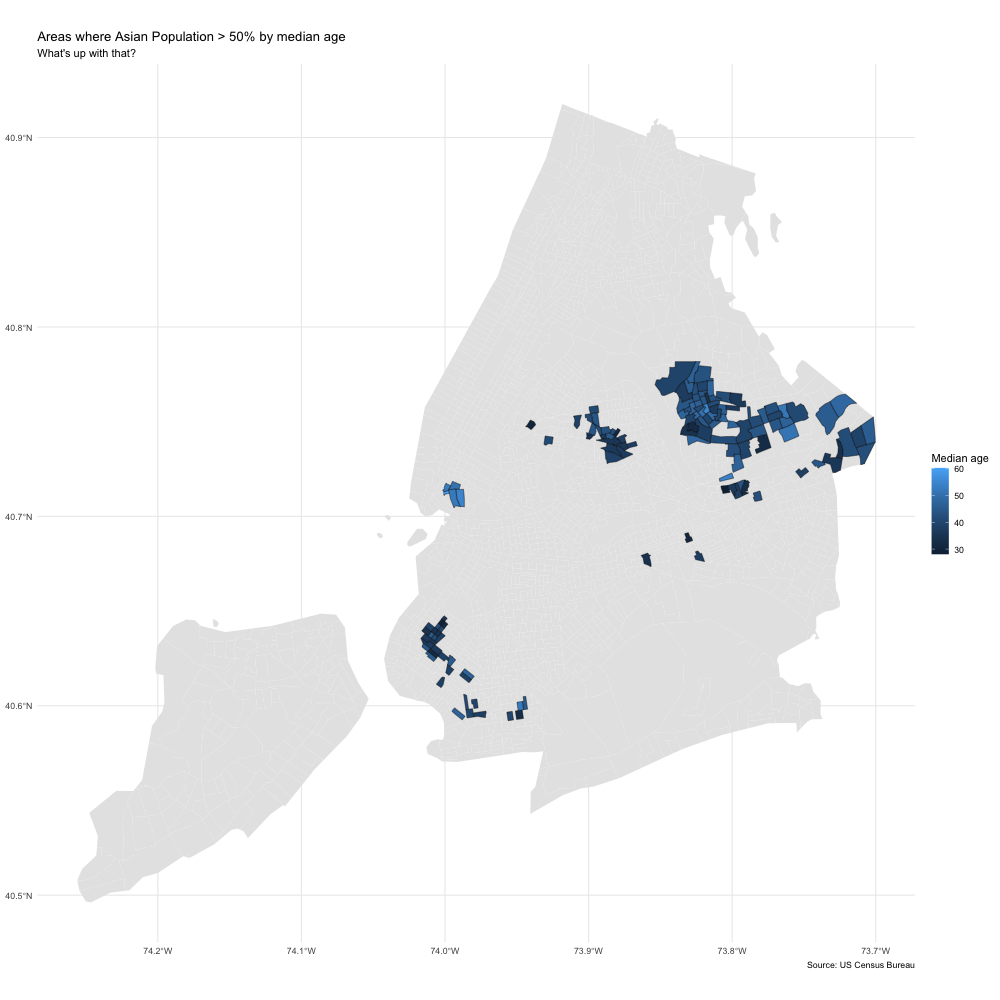

In [76]:
%%R -w 1000 -h 1000

asian50 <- nyc_census_data %>%
  filter(asian_percent > 50)

ggplot() +
  geom_sf(data = nyc_census_data, fill = "grey90", color = NA) +
  geom_sf(data = asian50, aes(fill = age_estimate), color = "black", linewidth = 0.2) +
  theme_minimal() +
  labs(title = "Areas where Asian Population > 50% by median age", fill = "Median age",
      subtitle = "What's up with that?",
      caption = "Source: US Census Bureau")


In [70]:
%%R

library(sf)
library(dplyr)
library(stringr)

# filtered tracts
asian50 <- nyc_census_data %>% 
  filter(asian_percent > 50)

# NYC NTA boundaries
nta <- st_read("https://data.cityofnewyork.us/resource/9nt8-h7nd.geojson", quiet = TRUE) %>%
  st_transform(st_crs(asian50))

# match each tract to an NTA using a point-in-polygon (cleaner than intersection)
asian50_pts <- asian50 %>%
  mutate(pt = st_point_on_surface(geometry)) %>%
  st_as_sf(sf_column_name = "pt")

asian50_with_nta <- st_join(asian50_pts, nta[, c("ntaname")], join = st_within)

# count how many tracts in each neighborhood
asian50_with_nta %>%
  st_drop_geometry() %>%
  count(ntaname, sort = TRUE)


# A tibble: 15 × 2
   ntaname                           n
   <chr>                         <int>
 1 <NA>                            108
 2 Elmhurst                          5
 3 East Flushing                     4
 4 Bensonhurst                       2
 5 Dyker Heights                     2
 6 Flushing-Willets Point            2
 7 Gravesend (West)                  2
 8 Murray Hill-Broadway Flushing     2
 9 Auburndale                        1
10 Bayside                           1
11 Bellerose                         1
12 South Ozone Park                  1
13 Sunnyside                         1
14 Sunset Park (Central)             1
15 Woodside                          1


In addition: Warning message:
There was 1 warning in `stopifnot()`.
ℹ In argument: `pt = st_point_on_surface(geometry)`.
Caused by warning in `st_point_on_surface.sfc()`:
! st_point_on_surface may not give correct results for longitude/latitude data 


In [60]:
%%R -w 1000 -h 1000

library(sf)
library(dplyr)
library(stringr)

# 读 NYC NTA 边界
nta <- st_read("https://data.cityofnewyork.us/resource/9nt8-h7nd.geojson", quiet = TRUE) %>%
  st_transform(st_crs(nyc_census_data))

top20 <- nyc_census_data %>%
  arrange(desc(age_estimate)) %>%
  slice(1:20)

# 用 tract 的中心点去匹配 NTA（比 intersection 更干净）
top20_with_nta <- top20 %>%
  mutate(pt = st_point_on_surface(geometry)) %>%
  st_drop_geometry() %>%
  bind_cols(st_coordinates(st_point_on_surface(top20$geometry)) %>% as.data.frame())

top20_sf <- top20 %>%
  mutate(pt = st_point_on_surface(geometry))

joined <- st_join(top20_sf["NAME"], nta[, c("ntaname")], join = st_within) %>%
  st_drop_geometry() %>%
  bind_cols(top20 %>% st_drop_geometry() %>% select(age_estimate, borough))

joined %>% arrange(desc(age_estimate))


# A tibble: 20 × 4
   NAME                                           ntaname   age_estimate borough
   <chr>                                          <chr>            <dbl> <chr>  
 1 Census Tract 277, New York County, New York    <NA>              90   New Yo…
 2 Census Tract 242, New York County, New York    <NA>              88   New Yo…
 3 Census Tract 178, New York County, New York    <NA>              87.1 New Yo…
 4 Census Tract 742, Kings County, New York       <NA>              83.9 Kings …
 5 Census Tract 652, Kings County, New York       <NA>              83.2 Kings …
 6 Census Tract 426, Bronx County, New York       <NA>              81.2 Bronx …
 7 Census Tract 892.01, Queens County, New York   <NA>              80.5 Queens…
 8 Census Tract 1142.01, Kings County, New York   <NA>              79.1 Kings …
 9 Census Tract 417, Kings County, New York       Bushwick…         79   Kings …
10 Census Tract 676, Kings County, New York       Flatlands         78.8 Kings …
11 Census

In addition: Warning messages:
1: There was 1 warning in `stopifnot()`.
ℹ In argument: `pt = st_point_on_surface(geometry)`.
Caused by warning in `st_point_on_surface.sfc()`:
! st_point_on_surface may not give correct results for longitude/latitude data 
2: In st_point_on_surface.sfc(top20$geometry) :
  st_point_on_surface may not give correct results for longitude/latitude data
3: There was 1 warning in `stopifnot()`.
ℹ In argument: `pt = st_point_on_surface(geometry)`.
Caused by warning in `st_point_on_surface.sfc()`:
! st_point_on_surface may not give correct results for longitude/latitude data 
